In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from scipy import stats # needed for ks test

from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False

plt.rcParams['svg.fonttype'] = 'none'

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


In [3]:
# load data
# set-up paths
home_dir = '/Volumes/Data/'
# home_dir = "/mnt/labNAS/"


in_path = home_dir+'Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = home_dir+'Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

# Raw count data - apply threshold, areas remain seperated
with open(in_path + 'M194_M220_ACA_separate_count4.pkl', 'rb') as f:
    aca_count = pickle.load(f)

# Load binarized data - apply threshold for bins
with open(in_path + 'M194_M220_ACA_separate_bin4.pkl', 'rb') as f:
    aca_bin = pickle.load(f)

# normalized count data - threshold = 4
with open(in_path + 'M194_M220_ACA_separate_countN4.pkl', 'rb') as f:
    aca_countN = pickle.load(f)
    


In [4]:
plot_areas = ['ACAi','ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'HIP', 'AMY', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']
aca_countN_cdf, foo = dfs_to_cdf(aca_countN, plot_areas=plot_areas)
aca_countN_cdf

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for HIP MMF3
NO BARCODES, cannot compute ECDF for HIP STM2
NO BARCODES, cannot compute ECDF for HIP STF3
NO BARCODES, cannot compute ECDF for HIP STF4
NO BARCODES, cannot compute ECDF for AMY STF4


,x,cdf,mice,species,dataset,area
0,0.000649,0.0,MMM1,MMus,M194,ACAi
1,0.000654,0.0,MMM1,MMus,M194,ACAi
2,0.000660,0.0,MMM1,MMus,M194,ACAi
3,0.000666,0.0,MMM1,MMus,M194,ACAi
4,0.000672,0.0,MMM1,MMus,M194,ACAi
...,...,...,...,...,...,...
995,0.926776,1.0,STM7,STeg,M220,RN
996,0.933397,1.0,STM7,STeg,M220,RN
997,0.940065,1.0,STM7,STeg,M220,RN
998,0.946781,1.0,STM7,STeg,M220,RN


# Normalize by median(s)

In [5]:
# Calculate median BC to possibly use for batch correction (across all target regions)
targets = ['ACAc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']

medians = pd.DataFrame(columns=["inj_med", "target_med", "all_med",
                                "mice", "species", "dataset"])


for i in range(metadata.shape[0]):
    df = aca_countN[i]

    # take nonzero median of injection site (ACAi)
    acai = df["ACAi"]
    acai = acai[acai!=0]
    inj_med = acai.median()

    # calculate median from just nonzero countN in target sites
    target_bcN = pd.Series(dtype="float64")
    
    for area in targets:
       area_bc = df[area]
       area_bc = area_bc[area_bc!=0]
       target_bcN = pd.concat([target_bcN, area_bc])

    # calculate median of nonzero countN across whole brain
#     val_df = df.drop(["inj_site"], axis=1)
#     vals = val_df.values.flatten()
    vals = df.values.flatten()
    vals = vals[vals!=0]
    vals = vals[~np.isnan(vals)] # drop nans
    all_med = np.median(vals)
    
    target_med = target_bcN.median()

    row = [inj_med, target_med, all_med, 
           metadata.loc[i,"mice"], metadata.loc[i,"species"], metadata.loc[i,"dataset"]]

    medians.loc[i,:] = row

medians

,inj_med,target_med,all_med,mice,species,dataset
0,0.011437,0.004131,0.006481,MMM1,MMus,M194
1,0.005408,0.003462,0.003957,MMF2,MMus,M194
2,0.009274,0.003262,0.004671,MMF3,MMus,M194
3,0.017734,0.003006,0.004935,STM1,STeg,M194
4,0.018138,0.004075,0.005386,STM2,STeg,M194
5,0.01562,0.004619,0.005166,STF3,STeg,M194
6,0.067624,0.080205,0.075,MMM4,MMus,M220
7,0.052101,0.070707,0.06203,MMF5,MMus,M220
8,0.036283,0.136735,0.086861,STF4,STeg,M220
9,0.130887,0.118841,0.104587,STM5,STeg,M220


In [14]:
aca_countN[0]

,ACAc,ACAi,AMY,AOMCc,AOMCi,APAGd,APAGv,AUD,H2O_inj_ctl,H2O_targ_ctl,...,POMCc,POMCi,PPAGd,PPAGv,RN,SCm,SNr,STRd,STRv,TH
0,0.000000,0.020206,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.001755,0.0,0.005718,0.002611,0.004223
1,0.001502,0.016393,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.021283,0.001382,0.000000
2,0.005446,0.020968,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.002065,0.000000,0.000000
3,0.000000,0.010865,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.003177,0.000000,0.006435
4,0.009202,0.011056,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8516,0.000000,0.007053,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.001169,0.0,0.0,0.004914,0.0,0.009053,0.003378,0.004223
8517,0.001690,0.014297,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
8518,0.005070,0.025162,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.009530,0.000000,0.000000
8519,0.006573,0.006862,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.026048,0.000000,0.000000


In [17]:
to_plot = ['ACAi', 'ACAc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 
           'SCm', 'PG', 'PAG', 'RN']
to_drop = ['OB', 'AOMCi', 'POMCi', 'AOMCc', 'POMCc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']

# combine areas
aca_countN_comb = df_combine_areas(aca_countN, to_drop=to_drop, combine=["STR", "PAG"], col_order=to_plot, )
aca_bin_comb = df_combine_areas(aca_bin, to_drop=['OB', 'AOMCi', 'POMCi', 'AOMCc', 'POMCc', 'HIP'],
                                rename={"RN":"BS"}, combine=["STR", "PAG"],
                                col_order = to_plot)

# normalize by all barcodes median
aca_countN_med = []
for i in range(len(aca_countN_comb)):
    df = aca_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "all_med"]
    aca_countN_med.append(df_m)

# normalize by inj barcodes median
aca_countN_med_inj = []
for i in range(len(aca_countN_comb)):
    df = aca_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    aca_countN_med_inj.append(df_m)

# apply cell type to median inj normalized
cell_types = [sort_by_celltype(df, sort=False, it_areas=["ACAc", "AUD", "STR"]) for df in aca_bin_comb]
for i in range(metadata.shape[0]):
    aca_countN_med_inj[i]["type"] = cell_types[i]["type"]

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_th['type'] = "CT"
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_nth['type'] = "IT"
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [18]:
# seperate by cell types
all_types = aca_countN_med_inj.copy()
it_types = [df[df["type"]=="IT"] for df in aca_countN_med_inj]
pt_types = [df[df["type"]=="PT"] for df in aca_countN_med_inj]

# Plot CDFs

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


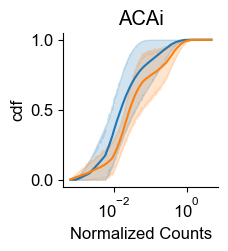

In [36]:
# all cell types - non-normalized data

plot_ind = [["ACAi"]]
labels = ["ACAi"]

# NOTE: USED COUNTN data

# plot ACAi, ACAc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(aca_countN, plot_areas=area, color_by="species", title=None, legend=False, 
             individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_all.svg", dpi=300, bbox_inches="tight")
    plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


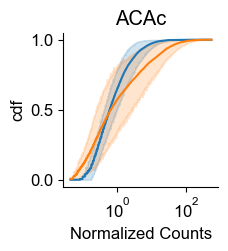

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


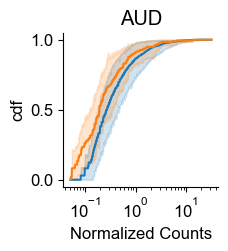

In [22]:
# plot by cell types - IT
# plot_ind = [['ACAc'], ['AUD'], ['STR']]
# labels = ['ACAc', 'AUD', 'STR']
plot_ind = [['ACAc'], ['AUD']]
labels = ['ACAc', 'AUD']


# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot ACAi, ACAc, AUD
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(it_types, plot_areas=area, color_by="species", title=None, 
             legend=False, individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_it.svg", dpi=300, bbox_inches="tight")
    plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


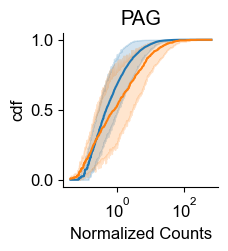

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


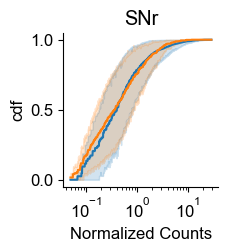

In [23]:
# plot by cell types - PT
# plot_ind = [['TH'], ['HY'], ['AMY'], ['PAG'], ['SNr'], ['SCm'],['PG'], ['RN']]
# labels = ['TH', 'HY', 'AMY', 'PAG', 'SNr', 'SCm',
#        'PG', 'RN']

plot_ind = [['PAG'], ['SNr']]
labels = ['PAG', 'SNr']

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot PAG, SNr 
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(pt_types, plot_areas=area, color_by="species", title=None, 
             legend=False, individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_pt.svg", dpi=300, bbox_inches="tight")
    plt.show()


# plot medians as dot plots

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:205: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


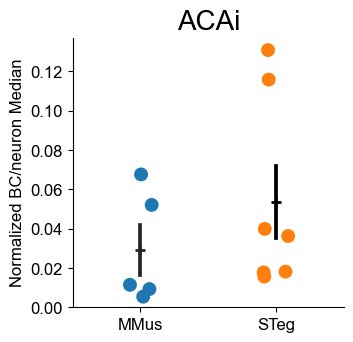

In [38]:
# plot non-median normalized data for injection site
plot_med = dfs_to_medians(aca_countN, drop=[])
to_plot = ["ACAi"]
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    # plt.savefig(out_path+"median_"+area+"dotplot_all.svg", dpi=300, bbox_inches="tight")

    plt.show()

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:205: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


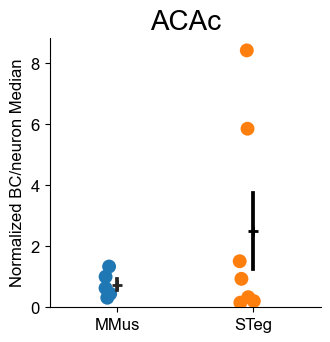

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:205: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


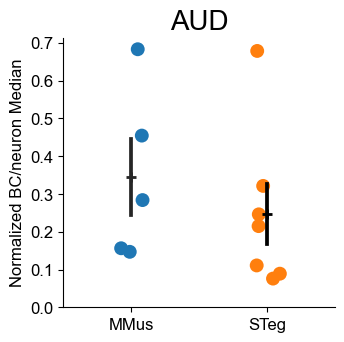

In [39]:
plot_med = dfs_to_medians(it_types, drop=["type"])
to_plot = ["ACAc", "AUD"]
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    # plt.savefig(out_path+"median_"+area+"dotplot_it.svg", dpi=300, bbox_inches="tight")

    plt.show()

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:205: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


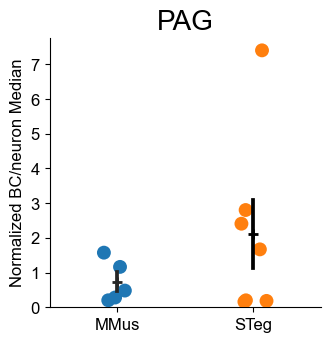

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:205: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


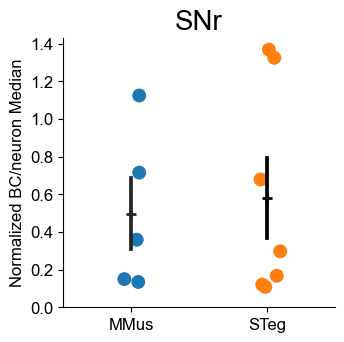

In [40]:
plot_med = dfs_to_medians(pt_types, drop=["type"])
to_plot = ["PAG", "SNr"]
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    # plt.savefig(out_path+"median_"+area+"dotplot_pt.svg", dpi=300, bbox_inches="tight")

    plt.show()

# scatter and volcano
- can only compare 2 samples at a time w/ KS
- decided to look at median per area so can compare across groups

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


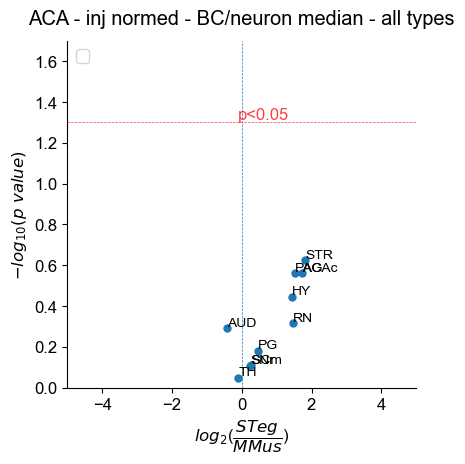

In [41]:
# all bcs, no cell type separation
plot_med = dfs_to_medians(aca_countN_med_inj, drop=["type"])
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, p_01=False, title="ACA - inj normed - BC/neuron median - all types", 
             xlim=(-5,5), fig_size=(4.5,4.5))

# plt.savefig(out_path+"volcano_comb_inj_med_all.svg", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
it_med = dfs_to_medians(it_types, drop=["ACAi", "type"])
it_med['type'] = "IT"
pt_med = dfs_to_medians(pt_types, drop=["ACAi", "type"])
pt_med['type'] = "PT"
all_med = pd.concat([it_med, pt_med]).dropna().reset_index(drop=True)
# all_med.tail(10)

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:791: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


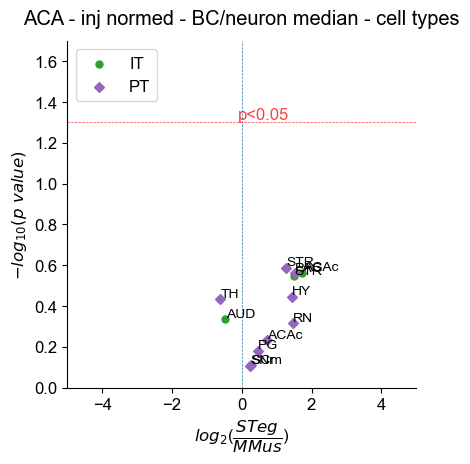

In [43]:
# volcano
# plot_med = dfs_to_medians(aca_countN_med_inj, drop=["ACAi", "type"])
plot = stvmm_calc_ttest(all_med, sp1="MMus", sp2="STeg", to_plot="median")
plot_volcano(plot, p_01=False, shape="type", title="ACA - inj normed - BC/neuron median - cell types", 
             xlim=(-5,5), fig_size=(4.5,4.5))

# plt.savefig(out_path+"volcano_comb_inj_med_celltypes.svg", dpi=300, bbox_inches="tight")
plt.show()